# Actividad Deep Vision

**Nombre del grupo:** GRUPO 8

**Integrantes:**
- Ricardo Castillo
- Miriam
- Katherine

---

## 📌 Objetivo del proyecto

Comparar dos estrategias de clasificación de imágenes en el dataset CIFAR100: (1) Transfer learning con redes preentrenadas, y (2) Entrenamiento de una red desde cero.

## 🔢 Carga y visualización de datos
Cargamos el dataset CIFAR100 y visualizamos algunas imágenes para familiarizarnos con los datos.

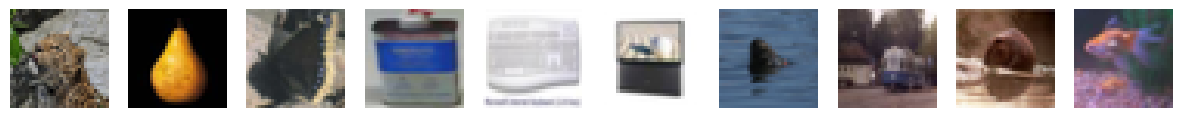

In [2]:
from tensorflow.keras.datasets import cifar100
import matplotlib.pyplot as plt
import numpy as np

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

# Mostrar 10 imágenes aleatorias
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    idx = np.random.randint(0, len(x_train))
    axes[i].imshow(x_train[idx])
    axes[i].axis('off')
plt.show()

## 🔹 Estrategia 1: Transfer Learning + Fine-Tuning

### 📦 Preparación de los datos
Redimensionamiento, normalización y creación de generadores de datos.

In [3]:
## Importamos herramientas necesarias
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.resnet50 import preprocess_input
#import tensorflow as tf
#
## Definimos tamaño objetivo para las imágenes (ResNet50 espera 224x224) y el tamaño del lote
#IMG_SIZE = 224
#BATCH_SIZE = 32
#
## Generador de datos de entrenamiento con augmentación + preprocesado ResNet50
#train_datagen = ImageDataGenerator(
#    preprocessing_function=preprocess_input,   # aplica el mismo preprocesado que ResNet50 usó en ImageNet
#    rotation_range=15,                         # rotación aleatoria (máx 15°)
#    width_shift_range=0.1,                     # desplazamiento horizontal aleatorio
#    height_shift_range=0.1,                    # desplazamiento vertical aleatorio
#    horizontal_flip=True                       # voltea aleatoriamente las imágenes horizontalmente
#)
#
## Generador de datos de test (sin augmentación, solo preprocesado)
#test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
#
## Generadores de imágenes para entrenamiento y test, con resize aplicado
#train_generator = train_datagen.flow(
#    tf.image.resize(x_train, (IMG_SIZE, IMG_SIZE)),  # redimensiona cada imagen a 224x224
#    y_train,                                         # etiquetas del conjunto de entrenamiento
#    batch_size=BATCH_SIZE                           # tamaño del lote
#)
#
#test_generator = test_datagen.flow(
#    tf.image.resize(x_test, (IMG_SIZE, IMG_SIZE)),   # redimensiona imágenes de test
#    y_test,                                          # etiquetas del conjunto de test
#    batch_size=BATCH_SIZE                           # tamaño del lote
#)
#

In [4]:
# Preprocesamiento eficiente con tf.data.Dataset
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

IMG_SIZE = 224
BATCH_SIZE = 32

# Función para redimensionar y preprocesar cada imagen
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))     # Resize a 224x224
    image = preprocess_input(image)                          # Preprocesado específico de ResNet50
    return image, label

# Dataset de entrenamiento
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Dataset de validación/test
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


### 🔍 Comparación de arquitecturas preentrenadas
Probaremos al menos dos modelos como ResNet50 y MobileNetV2.

### ResNet50 preentrenado (sin capas superiores)

#### Modelaje y explicación del modelo

In [5]:
# 🧠 Importamos componentes clave para construir el modelo
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 📦 Cargamos la arquitectura base ResNet50 sin su parte superior (clasificación de ImageNet)
base_model = ResNet50(
    weights='imagenet',               # Usamos pesos preentrenados en ImageNet
    include_top=False,                # Quitamos las capas de clasificación final
    input_tensor=Input(shape=(224, 224, 3))  # Entrada esperada por ResNet50
)

# ❄️ Congelamos las capas del modelo base para que no se entrenen aún
base_model.trainable = False

# 🧱 Construimos la "cabeza" del modelo adaptada a CIFAR100
x = base_model.output                           # Salida del modelo base
x = GlobalAveragePooling2D()(x)                 # Convierte los mapas de activación en un vector
x = Dense(256, activation='relu')(x)            # Capa densa intermedia
x = Dropout(0.5)(x)                              # Dropout para regularización
output = Dense(100, activation='softmax')(x)    # Capa de salida con 100 neuronas (una por clase)

# 🔗 Creamos el modelo final combinando base y top
modelo = Model(inputs=base_model.input, outputs=output)

# ⚙️ Compilamos el modelo indicando optimizador, función de pérdida y métricas
modelo.compile(
    optimizer=Adam(learning_rate=0.001),             # Optimizador Adam
    loss='sparse_categorical_crossentropy',          # Para etiquetas enteras (no one-hot)
    metrics=['accuracy']                             # Métrica de evaluación
)

# 🧾 Mostramos el resumen del modelo
modelo.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,137,956 (92.08 MB)

 Trainable params: 550,244 (2.10 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 **🧾 Resumen del modelo (explicación)**

El modelo está compuesto por **ResNet50 como base (sin su top)** y un **top model personalizado**.
Se están usando pesos **preentrenados en ImageNet**, y todas las capas de ResNet50 están **congeladas**, es decir, **no se reentrenan en esta fase**.

El top model incluye:
- Una capa de **GlobalAveragePooling2D** que reduce la dimensión del output de ResNet50.
- Una capa **Dense (256, ReLU)** que actúa como clasificador intermedio.
- Un **Dropout del 50%** para evitar sobreajuste.
- Una capa **Dense final de 100 neuronas con softmax**, correspondiente a las 100 clases de CIFAR100.

 **📊 Parámetros del modelo:**
- **Total de parámetros**: `24,137,956`  
  Es la suma de todos los pesos del modelo completo (base + top).
- **Parámetros entrenables**: `550,244`  
  Solo corresponden al top model, que es la parte que estamos entrenando ahora.
- **Parámetros no entrenables**: `23,587,712`  
  Son los pesos de la ResNet50, que están congelados y **no se actualizan** durante esta fase.

✅ En esta fase solo estamos enseñando a la “cabeza” del modelo cómo clasificar imágenes de CIFAR100 usando lo que ResNet ya sabe.


#### Entrenamiento de la primera fase (solo top model)

In [6]:
# Callback para parar el entrenamiento si no mejora en 5 épocas seguidas
early_stop = EarlyStopping(
    patience=5,                     # Número de épocas sin mejora antes de parar
    restore_best_weights=True      # Vuelve a los pesos con mejor validación
)

# Callback para reducir el learning rate si no mejora en 3 épocas
reduce_lr = ReduceLROnPlateau(
    patience=3,                    # Épocas sin mejora antes de reducir el LR
    factor=0.5,                    # Reduce el LR a la mitad
    verbose=1                      # Muestra mensaje cuando se reduzca el LR
)

# Entrenamiento del modelo (solo el top model, ResNet50 congelado)
history = modelo.fit(
    train_dataset,                 # Dataset de entrenamiento procesado con tf.data
    epochs=20,                     # Número máximo de épocas
    validation_data=test_dataset,  # Validación sobre el set de test
    callbacks=[early_stop, reduce_lr]  # Callbacks para optimización del entrenamiento
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 184s 108ms/step - accuracy: 0.3272 - loss: 2.7795 - val_accuracy: 0.6393 - val_loss: 1.2536 - learning_rate: 0.0010
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 184s 102ms/step - accuracy: 0.5456 - loss: 1.6209 - val_accuracy: 0.6608 - val_loss: 1.1557 - learning_rate: 0.0010
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 201s 101ms/step - accuracy: 0.5821 - loss: 1.4660 - val_accuracy: 0.6704 - val_loss: 1.1255 - learning_rate: 0.0010
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 202s 101ms/step - accuracy: 0.6001 - loss: 1.3838 - val_accuracy: 0.6795 - val_loss: 1.1024 - learning_rate: 0.0010
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 202s 101ms/step - accuracy: 0.6180 - loss: 1.3119 - val_accuracy: 0.6777 - val_loss: 1.1025 - learning_rate: 0.0010
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 158s 101ms/step - accuracy: 0.6338 - loss: 1.2554 - val_accuracy: 0.6858 - val_loss: 1.0825 - learning_rate: 0.0010
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 217s 111ms/step - acc

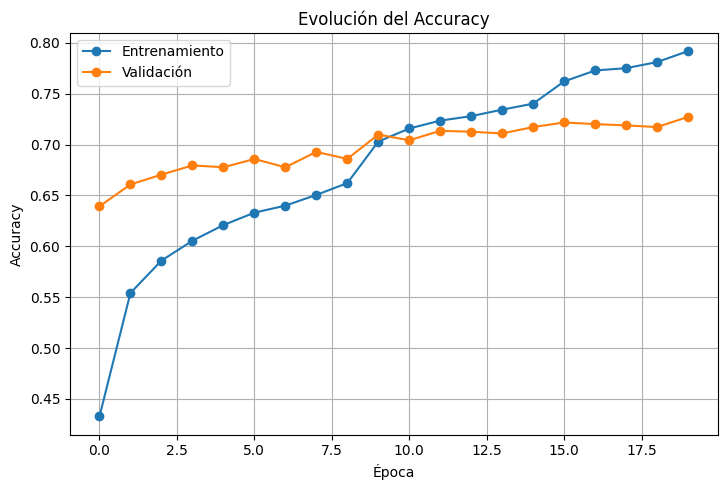

In [10]:
# 📊 Visualización de métricas de entrenamiento
import matplotlib.pyplot as plt

# Ajustamos el tamaño de las figuras
plt.figure(figsize=(14, 5))

# --- Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', marker='o')
plt.plot(history.history['val_accuracy'], label='Validación', marker='o')
plt.title('Evolución del Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


**📈 Gráfica 1: Evolución del Accuracy**

**🔵 Línea azul (Entrenamiento):**

- Comienza baja (~43%) y sube de forma estable hasta ~79%. Esto indica que el modelo aprende progresivamente sin estancarse.

- No hay saltos bruscos, ni picos raros, por lo que el aprendizaje es suave y constante.

**🟠 Línea naranja (Validación):**

- Empieza fuerte (~64%) y sube hasta estabilizarse en torno al 72–73%.

- Al principio, el val_accuracy es mayor que el de entrenamiento, lo que es típico cuando el modelo aún no ha memorizado bien.

- Luego se estabiliza, lo cual es buena señal: no hay sobreajuste evidente.

**✅ Conclusión Accuracy:**

Modelo bien entrenado, sin señales de overfitting. Hemos exprimido bien la cabeza (top model) del ResNet50.

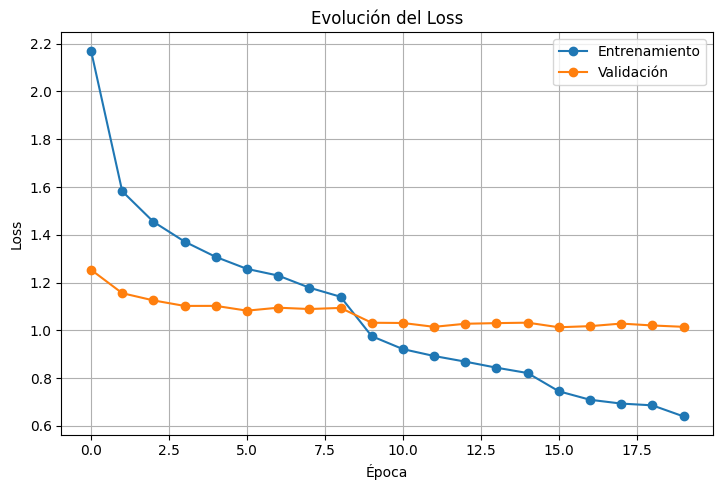

In [9]:
# 📊 Visualización de métricas de entrenamiento
import matplotlib.pyplot as plt

# Ajustamos el tamaño de las figuras
plt.figure(figsize=(14, 5))

# --- Loss ---
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', marker='o')
plt.plot(history.history['val_loss'], label='Validación', marker='o')
plt.title('Evolución del Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

**📉 Gráfica 2: Evolución del Loss**

**🔵 Línea azul (Entrenamiento):**

- Baja con fuerza de ~2.2 a ~0.65. Esto indica que el modelo reduce errores internos progresivamente.

- Curva suave, sin rebotes, lo que muestra aprendizaje sano.

**🟠 Línea naranja (Validación):**

- Baja hasta ~1.02 y luego se mantiene bastante estable entre épocas 8 y 20.

- No vuelve a subir con fuerza → no hay señales de que el modelo esté empezando a sobreajustar.

**✅ Conclusión Loss:**
El modelo llega a una zona de estancamiento lógico para el top model. La red ha aprendido lo que podía sin refinar el cuerpo (ResNet50).

In [11]:
#Guardamos el modelo:

modelo.save("resnet_top_model.h5")

#Para cargarlo:

#from tensorflow.keras.models import load_model
#modelo = load_model("resnet_top_model.h5")


In [12]:
#Guardamos las métricas para posterior análisis:

import pickle

with open("history_resnet_top.pkl", "wb") as f:
    pickle.dump(history.history, f)

#Para cargarlas después:

#with open("history_resnet_top.pkl", "rb") as f:
 #   history_data = pickle.load(f)



In [13]:
# Para guardarlos en Drive:

from google.colab import drive
import pickle

# 🔗 Montar Google Drive
drive.mount('/content/drive')

# 📦 Guardar el modelo entrenado en Drive
modelo.save('/content/drive/MyDrive/resnet_top_model.h5')
print("✅ Modelo guardado en tu Google Drive como 'resnet_top_model.h5'")

# 📈 Guardar historial de entrenamiento
with open('/content/drive/MyDrive/history_resnet_top.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("✅ Historial guardado en tu Google Drive como 'history_resnet_top.pkl'")


Mounted at /content/drive
✅ Modelo guardado en tu Google Drive como 'resnet_top_model.h5'
✅ Historial guardado en tu Google Drive como 'history_resnet_top.pkl'


### MobileNetV2

## 🔸 Estrategia 2: Red desde cero (Custom CNN)

### 🧱 Diseño de la arquitectura personalizada
Aquí definimos una CNN desde cero con técnicas de optimización.

In [ ]:
# Aquí irá el modelo CNN diseñado desde cero, con batch normalization, dropout y otras técnicas.

## 📈 Comparación y evaluación

In [ ]:
# Código para comparar las métricas de ambas estrategias (accuracy, curvas de pérdida, etc.)

## 🧠 Conclusiones

Aquí se discutirán los resultados obtenidos con ambas estrategias, sus ventajas, desventajas y posibles mejoras futuras.